In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , Flatten,Conv2D,MaxPool2D,AvgPool2D
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder


def load_npy_files_from_folder(folder_path):
    frame_data = []
    labels = []
    maneuvers = os.listdir(folder_path)
    for maneuver in maneuvers:
        maneuver_path = os.path.join(folder_path, maneuver)
        npy_files = [file for file in os.listdir(maneuver_path) if file.endswith('.npy')]
        for npy_file in npy_files:
            npy_file_path = os.path.join(maneuver_path, npy_file)
            data = np.load(npy_file_path, allow_pickle=True).item() 
            resnet_features = data['resnet']
            timestamps = data['timestamps_ms']
            num_frames = len(resnet_features)  
            for i in range(num_frames):
                frame_data.append(resnet_features[i])
                labels.append(maneuver)
                
    return np.array(frame_data), np.array(labels)

frontal_folder = '/kaggle/input/rip-dataset/ResNet_Training_Features/frontal_view'
left_folder = '/kaggle/input/rip-dataset/ResNet_Training_Features/left_side_mirror_view'
right_folder = '/kaggle/input/rip-dataset/ResNet_Training_Features/right_side_mirror_view'

frontal_features, frontal_labels = load_npy_files_from_folder(frontal_folder)
left_features, left_labels = load_npy_files_from_folder(left_folder)
right_features, right_labels = load_npy_files_from_folder(right_folder)




In [4]:
label_encoder = LabelEncoder()
frontal_labels_encoded = label_encoder.fit_transform(frontal_labels)
left_labels_encoded = label_encoder.transform(left_labels)
right_labels_encoded = label_encoder.transform(right_labels)

num_classes = len(label_encoder.classes_)
frontal_labels_one_hot = to_categorical(frontal_labels_encoded, num_classes)
left_labels_one_hot = to_categorical(left_labels_encoded, num_classes)
right_labels_one_hot = to_categorical(right_labels_encoded, num_classes)

def split_data(features, labels):
    train_val_features, test_features, train_val_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=42)
    train_features, val_features, train_labels, val_labels = train_test_split(
        train_val_features, train_val_labels, test_size=0.2, random_state=42)
    return train_features, val_features, test_features, train_labels, val_labels, test_labels

frontal_train_features, frontal_val_features, frontal_test_features, frontal_train_labels, frontal_val_labels, frontal_test_labels = split_data(frontal_features, frontal_labels_one_hot)
left_train_features, left_val_features, left_test_features, left_train_labels, left_val_labels, left_test_labels = split_data(left_features, left_labels_one_hot)
right_train_features, right_val_features, right_test_features, right_train_labels, right_val_labels, right_test_labels = split_data(right_features, right_labels_one_hot)


In [15]:
def reshape_features(features, height, width, channels):
    num_samples = features.shape[0]
    return features.reshape(num_samples, height, width, channels)

height = 32
width = 64
channels = 1

frontal_train_features = reshape_features(frontal_train_features, height, width, channels)
frontal_val_features = reshape_features(frontal_val_features, height, width, channels)
frontal_test_features = reshape_features(frontal_test_features, height, width, channels)
left_train_features = reshape_features(left_train_features, height, width, channels)
left_val_features = reshape_features(left_val_features, height, width, channels)
left_test_features = reshape_features(left_test_features, height, width, channels)

right_train_features = reshape_features(right_train_features, height, width, channels)
right_val_features = reshape_features(right_val_features, height, width, channels)
right_test_features = reshape_features(right_test_features, height, width, channels)
from tensorflow.keras import models,layers,Input
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

def frontal_view_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.AvgPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.Conv2D(filters)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model
    
#     input_layer = Input(shape=input_shape)
#     x = layers.Dense(1024, activation='relu')(input_layer)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     output_layer = layers.Dense(num_classes, activation='softmax')
#     model = models.Model(inputs=input_layer, outputs=output_layer)
#     return model

def multi_view_model(input_shape, num_classes):
    input_frontal = Input(shape=input_shape)
    input_left = Input(shape=input_shape)
    input_right = Input(shape=input_shape)

    def dense_branch(x):
        x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = layers.AvgPool2D(pool_size=(2, 2), strides=(2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
#         x = layers.Dense(1024, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(512, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dense(64, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.5)(x)
        return x

    frontal_branch = dense_branch(input_frontal)
    left_branch = dense_branch(input_left)
    right_branch = dense_branch(input_right)

    combined_features = layers.Concatenate()([frontal_branch, left_branch, right_branch])

    output = layers.Dense(num_classes, activation='softmax')(combined_features)

    model = models.Model(inputs=[input_frontal, input_left, input_right], outputs=output)

    return model

def f1_metric(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(f1_score, (y_true, y_pred), tf.double)

input_shape = frontal_train_features.shape[1:]
num_classes = frontal_train_labels.shape[1]

frontal_model = frontal_view_model(input_shape, num_classes)
multi_view_model = multi_view_model(input_shape, num_classes)

frontal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
multi_view_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_frontal = ModelCheckpoint('best_frontal_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_multi_view = ModelCheckpoint('best_multi_view_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history_frontal = frontal_model.fit(
    frontal_train_features, frontal_train_labels,
    epochs=30, 
    validation_data=(frontal_val_features, frontal_val_labels),
    callbacks=[checkpoint_frontal, early_stopping]
)

history_multi_view = multi_view_model.fit(
    [frontal_train_features, left_train_features, right_train_features], frontal_train_labels,
    epochs=30, 
    validation_data=([frontal_val_features, left_val_features, right_val_features], frontal_val_labels),
    callbacks=[checkpoint_multi_view, early_stopping]
)



Epoch 1/30
  37/2257 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2745 - loss: 1.6617

W0000 00:00:1716553405.684725      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2257/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4775 - loss: 1.1670

W0000 00:00:1716553414.999707      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.67565, saving model to best_frontal_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.4775 - loss: 1.1669 - val_accuracy: 0.7123 - val_loss: 0.6757
Epoch 2/30
  25/2257 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7661 - loss: 0.5625 

W0000 00:00:1716553416.288045      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2250/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.4720
Epoch 2: val_loss improved from 0.67565 to 0.34281, saving model to best_frontal_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8120 - loss: 0.4718 - val_accuracy: 0.8700 - val_loss: 0.3428
Epoch 3/30
2253/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.2762
Epoch 3: val_loss improved from 0.34281 to 0.26895, saving model to best_frontal_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8955 - loss: 0.2762 - val_accuracy: 0.8980 - val_loss: 0.2689
Epoch 4/30
2247/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9303 - loss: 0.1872
Epoch 4: val_loss improved from 0.26895 to 0.19506, saving model to best_frontal_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9304 - loss: 0.1872 - val_accuracy: 0.9304 - val_loss: 0.1951
Epoch 5/30
2251/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9468 - loss: 0.1444
Epoch 5: val_loss did n

W0000 00:00:1716553663.286428      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553663.288430      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553663.290499      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2257/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5045 - loss: 1.1182

W0000 00:00:1716553684.143596      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553684.145272      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553684.146884      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.42565, saving model to best_multi_view_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.5046 - loss: 1.1180 - val_accuracy: 0.8321 - val_loss: 0.4256
Epoch 2/30
   1/2257 ━━━━━━━━━━━━━━━━━━━━ 1:10 31ms/step - accuracy: 0.9375 - loss: 0.3391

W0000 00:00:1716553686.227528      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553686.229261      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553686.230844      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2250/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8784 - loss: 0.3206
Epoch 2: val_loss improved from 0.42565 to 0.21322, saving model to best_multi_view_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8784 - loss: 0.3205 - val_accuracy: 0.9217 - val_loss: 0.2132
Epoch 3/30
2254/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9422 - loss: 0.1597
Epoch 3: val_loss improved from 0.21322 to 0.15401, saving model to best_multi_view_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9422 - loss: 0.1597 - val_accuracy: 0.9447 - val_loss: 0.1540
Epoch 4/30
2254/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9591 - loss: 0.1153
Epoch 4: val_loss improved from 0.15401 to 0.15332, saving model to best_multi_view_model.keras
2257/2257 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9591 - loss: 0.1153 - val_accuracy: 0.9464 - val_loss: 0.1533
Epoch 5/30
2250/2257 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9684 - loss: 0.0891
Epoch 5: va

In [16]:
best_frontal_model = load_model('best_frontal_model.keras')
best_multi_view_model = load_model('best_multi_view_model.keras')
frontal_eval = best_frontal_model.evaluate(frontal_test_features, frontal_test_labels)
multi_view_eval = best_multi_view_model.evaluate([frontal_test_features, left_test_features, right_test_features], frontal_test_labels)

print(f"Frontal Model Accuracy: {frontal_eval[1]}")
print(f"Frontal Model Loss: {frontal_eval[0]}")
print(f"Multi-View Model Accuracy: {multi_view_eval[1]}")
print(f"Multi-View Model Loss: {multi_view_eval[0]}")

 79/706 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0588

W0000 00:00:1716553896.841857      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9794 - loss: 0.0660
 44/706 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9714 - loss: 0.0762

W0000 00:00:1716553901.548896      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553901.550655      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716553901.552442      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9709 - loss: 0.0862
Frontal Model Accuracy: 0.9797899127006531
Frontal Model Loss: 0.0681225061416626
Multi-View Model Accuracy: 0.9703496694564819
Multi-View Model Loss: 0.08897769451141357


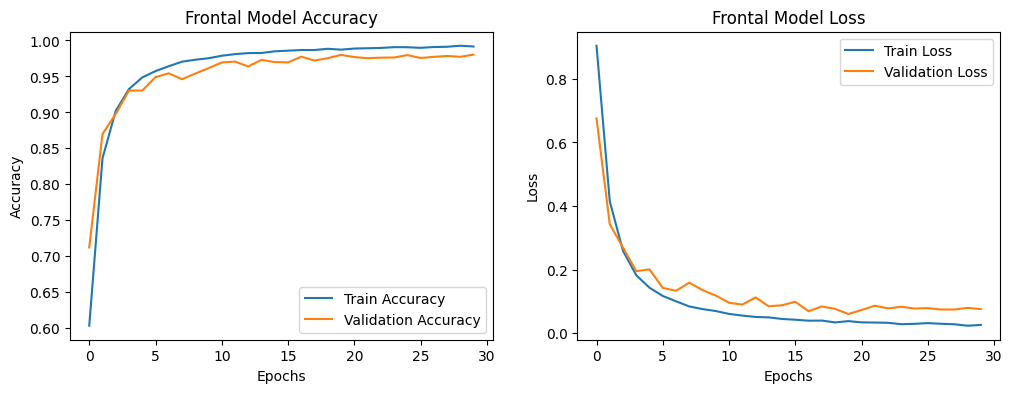

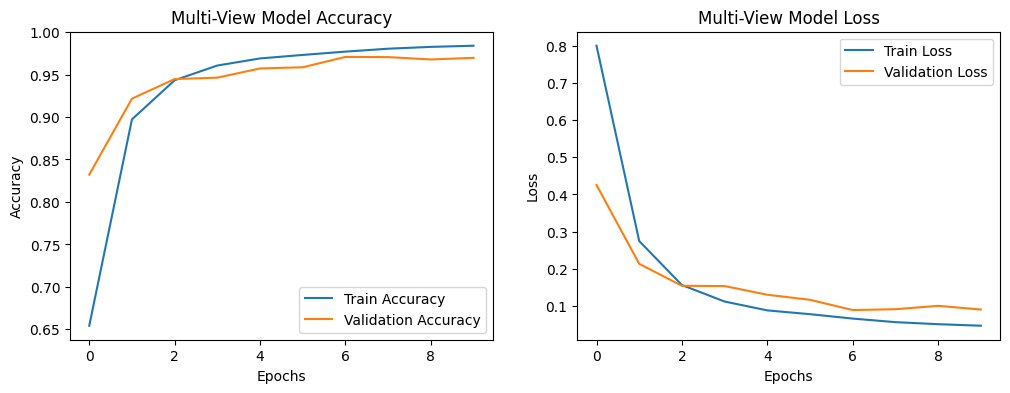

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_frontal.history['accuracy'], label='Train Accuracy')
plt.plot(history_frontal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Frontal Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_frontal.history['loss'], label='Train Loss')
plt.plot(history_frontal.history['val_loss'], label='Validation Loss')
plt.title('Frontal Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multi_view.history['accuracy'], label='Train Accuracy')
plt.plot(history_multi_view.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-View Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multi_view.history['loss'], label='Train Loss')
plt.plot(history_multi_view.history['val_loss'], label='Validation Loss')
plt.title('Multi-View Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()